In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
data = pd.read_csv('oil_price_cleaned.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

price = data['Price'].astype(float)

# Split data into train and test sets
train_size = int(len(price) * 0.8)
train = price.iloc[:train_size]
test  = price.iloc[train_size:]

print(f"Total={len(price)}, Train={len(train)}, Test={len(test)}")

Total=2503, Train=2002, Test=501


[L=10] CV best RMSE=3.4906 | Test RMSE=1.5117, MAE=1.1639, MAPE=1.561%
  best_params: {'svr__C': 1000, 'svr__epsilon': 0.01, 'svr__gamma': 0.01}
[L=20] CV best RMSE=4.7396 | Test RMSE=1.5399, MAE=1.1927, MAPE=1.599%
  best_params: {'svr__C': 1000, 'svr__epsilon': 0.01, 'svr__gamma': 0.01}
[L=40] CV best RMSE=9.1259 | Test RMSE=1.5294, MAE=1.1863, MAPE=1.590%
  best_params: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.01}
[L=80] CV best RMSE=13.6297 | Test RMSE=1.7593, MAE=1.3347, MAPE=1.800%
  best_params: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.01}

=== Summary (sorted by Test RMSE) ===
    L  cv_best_RMSE  TEST_RMSE  TEST_MAE  TEST_MAPE_%  \
0  10      3.490622   1.511664  1.163866     1.561180   
1  40      9.125861   1.529368  1.186307     1.590483   
2  20      4.739606   1.539855  1.192675     1.599385   
3  80     13.629687   1.759333  1.334688     1.799817   

                                         best_params  
0  {'svr__C': 1000, 'svr__epsilon': 0.01, '

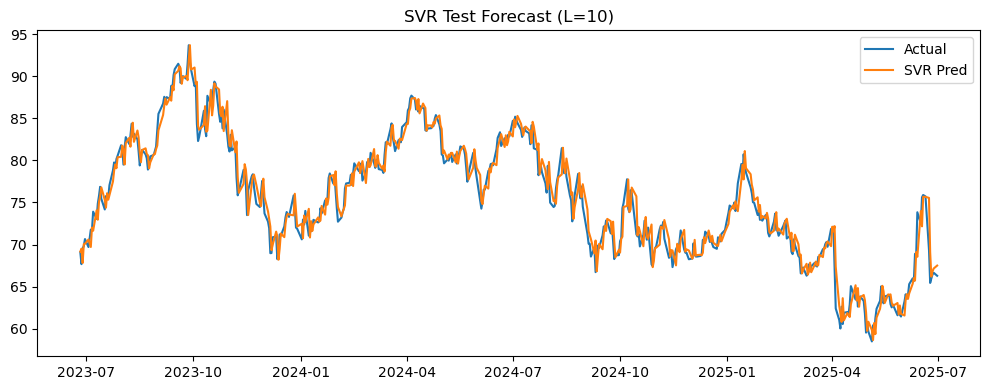

In [7]:
# Construct lag features for supervised learning
def make_supervised(series: pd.Series, L: int):
    """
    Given a univariate time series, construct a supervised learning matrix [lag_1 ... lag_L] -> y_t.
    Returns X, y, idx (index aligned with y).
    """
    df = pd.DataFrame({'y': series})
    for i in range(1, L + 1):
        df[f'lag_{i}'] = series.shift(i)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, L + 1)]].values
    y = df['y'].values
    return X, y, df.index

def make_test_matrix(train_series: pd.Series, test_series: pd.Series, L: int):
    """
    After concatenating the last L entries of the training set with the entire test set,
    construct lag features so that the number of samples matches the test set length,
    and each row only uses historical information.
    """
    s = pd.concat([train_series.iloc[-L:], test_series])
    X_all, y_all, idx_all = make_supervised(s, L)
    # Since the first L entries are used to generate the lag for the first test sample,
    # the resulting y_all / idx_all after dropna align with each time point in the test set, length == len(test_series)
    assert len(y_all) == len(test_series)
    return X_all, y_all, idx_all

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0

# Search space and time series CV
L_candidates = [10, 20, 40, 80]   # Your specified windows
tscv = TimeSeriesSplit(n_splits=5)

svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

param_grid = {
    'svr__C':      [0.1, 1, 10, 100, 1000],
    'svr__gamma':  ['scale', 0.01, 0.1, 1],
    'svr__epsilon':[0.01, 0.05, 0.1]
}
scoring = 'neg_root_mean_squared_error'  # Use validation RMSE as the objective

# Grid search + test evaluation for each L
results = []

for L in L_candidates:
    # Training set supervised matrix (constructed only from the training segment) ---
    X_tr, y_tr, idx_tr = make_supervised(train, L)

    # Grid search (expanding window CV)
    gsv = GridSearchCV(
        estimator=svr_pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gsv.fit(X_tr, y_tr)

    # Evaluate on the test set in one go
    X_te, y_te, idx_te = make_test_matrix(train, test, L)
    y_pred = gsv.best_estimator_.predict(X_te)

    res = {
        'L': L,
        'best_params': gsv.best_params_,
        'cv_best_RMSE': -gsv.best_score_,  # 取反还原
        'TEST_MAE':  mean_absolute_error(y_te, y_pred),
        'TEST_RMSE': rmse(y_te, y_pred),
        'TEST_MAPE_%': mape(y_te, y_pred)
    }
    results.append(res)
    print(f"[L={L}] CV best RMSE={res['cv_best_RMSE']:.4f} | "
          f"Test RMSE={res['TEST_RMSE']:.4f}, MAE={res['TEST_MAE']:.4f}, MAPE={res['TEST_MAPE_%']:.3f}%")
    print(f"  best_params: {gsv.best_params_}")

# Summarize results and select the best L
res_df = pd.DataFrame(results).sort_values('TEST_RMSE').reset_index(drop=True)
print("\n=== Summary (sorted by Test RMSE) ===")
print(res_df[['L', 'cv_best_RMSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE_%', 'best_params']])

best_row = res_df.iloc[0]
best_L = int(best_row['L'])
print(f"\n>>> Best window L* = {best_L} (based on minimum test RMSE)")

# Plot actual vs predicted using the best L
# To quickly inspect the error structure, it is recommended to plot a test period curve
try:
    import matplotlib.pyplot as plt

    # Retrain the best model and generate test period predictions
    X_tr, y_tr, _ = make_supervised(train, best_L)
    gsv = GridSearchCV(svr_pipe, param_grid, cv=tscv, scoring=scoring, n_jobs=-1, refit=True)
    gsv.fit(X_tr, y_tr)
    X_te, y_te, idx_te = make_test_matrix(train, test, best_L)
    y_hat = gsv.best_estimator_.predict(X_te)

    plt.figure(figsize=(10, 4))
    plt.plot(idx_te, y_te, label='Actual')
    plt.plot(idx_te, y_hat, label='SVR Pred')
    plt.title(f'SVR Test Forecast (L={best_L})')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot skipped:", e)


In [10]:
# SVR Second Round Fine-tuning: Local L + gap + custom MAPE
import os, json
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

# Utility functions
def make_supervised(series: pd.Series, L: int):
    """Construct a supervised learning matrix with lag L: [lag_1 ... lag_L] -> y_t."""
    df = pd.DataFrame({'y': series})
    for i in range(1, L + 1):
        df[f'lag_{i}'] = series.shift(i)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, L + 1)]].values
    y = df['y'].values
    return X, y, df.index

def make_test_matrix(train_series: pd.Series, test_series: pd.Series, L: int):
    """
    After concatenating the last L entries of the training set with the entire test set,
    construct lag features so that the number of samples matches the test set length,
    and each row only uses historical information.
    """
    s = pd.concat([train_series.iloc[-L:], test_series])
    X_all, y_all, idx_all = make_supervised(s, L)
    assert len(y_all) == len(test_series)
    return X_all, y_all, idx_all

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_fn(y_true, y_pred, eps=1e-6):
    # Take absolute value of denominator and set a lower bound to avoid 0/near-zero; also explicitly convert to float
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.clip(np.abs(y_true), a_min=eps, a_max=None)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0


# Custom scorers (Note: sklearn scorers are "the larger the better", so we negate the metric)

mape_scorer = make_scorer(lambda yt, yp: -mape_fn(yt, yp), greater_is_better=True)
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp), greater_is_better=True)

# Search space
L_candidates = [6, 8, 10, 12, 16, 24, 32]
param_grid = {
    'svr__C':       [300, 600, 1000, 1500],
    'svr__gamma':   [0.005, 0.01, 0.02, 'scale'],
    'svr__epsilon': [0.005, 0.01, 0.02, 0.05],
}

svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

# Sequential L with gap time series CV + test evaluation
rows = []
pred_store = {}  # Store test predictions for each L for later comparison plots

for L in L_candidates:
    # Training supervised matrix (only use training segment)
    X_tr, y_tr, idx_tr = make_supervised(train, L)

    # Set TimeSeriesSplit and give priority to using gap=L; If the version does not support it, roll back to GAP-free
    try:
        tscv = TimeSeriesSplit(n_splits=5, gap=L)
        _ = list(tscv.split(X_tr))  # Trigger once to let old versions report error
    except TypeError:
        print(f"[L={L}] TimeSeriesSplit does not support gap parameter, rolling back to no gap.")
        tscv = TimeSeriesSplit(n_splits=5)

    gsv = GridSearchCV(
        estimator=svr_pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring={'neg_mape': mape_scorer,
                 'neg_mae': 'neg_mean_absolute_error',
                 'neg_rmse': rmse_scorer},
        refit='neg_mape',
        n_jobs=-1,
        verbose=0,
        return_train_score=False
    )
    gsv.fit(X_tr, y_tr)

    # Test period evaluation
    X_te, y_te, idx_te = make_test_matrix(train, test, L)
    y_pred = gsv.best_estimator_.predict(X_te)

    test_mae  = mean_absolute_error(y_te, y_pred)
    test_rmse = rmse(y_te, y_pred)
    test_mape = mape_fn(y_te, y_pred)

    # Record multiple CV best metrics (for the hyperparameters selected by refit='neg_mape')
    best_idx = gsv.best_index_
    cv_neg_mape = gsv.cv_results_['mean_test_neg_mape'][best_idx]
    cv_neg_mae  = gsv.cv_results_['mean_test_neg_mae'][best_idx]
    cv_neg_rmse = gsv.cv_results_['mean_test_neg_rmse'][best_idx]

    row = {
        'L': L,
        'cv_best_MAPE_%': -cv_neg_mape,
        'cv_best_MAE':    -cv_neg_mae,
        'cv_best_RMSE':   -cv_neg_rmse,
        'TEST_MAPE_%':    test_mape,
        'TEST_MAE':       test_mae,
        'TEST_RMSE':      test_rmse,
        'best_params':    json.dumps(gsv.best_params_)
    }
    rows.append(row)
    pred_store[L] = {'idx': idx_te, 'y_true': y_te, 'y_pred': y_pred}

    print(f"[L={L}] CV(best) MAPE={row['cv_best_MAPE_%']:.3f}% | "
          f"Test MAPE={test_mape:.3f}%, MAE={test_mae:.4f}, RMSE={test_rmse:.4f} | "
          f"best_params={gsv.best_params_}")

# Output
res_df = pd.DataFrame(rows).sort_values('TEST_RMSE').reset_index(drop=True)
os.makedirs('svr_outputs', exist_ok=True)
csv_path = os.path.join('svr_outputs', 'svr_refined_results.csv')
res_df.to_csv(csv_path, index=False)
print("\n=== Refined Summary (sorted by Test RMSE) ===")
print(res_df)

best_L = int(res_df.loc[0, 'L'])
print(f"\n>>> Best window L* after second round fine-tuning = {best_L}")

# Plot: Actual vs. Predicted for the best L
idx = pred_store[best_L]['idx']
y_true = pred_store[best_L]['y_true']
y_pred = pred_store[best_L]['y_pred']

plt.figure(figsize=(11, 4.5))
plt.plot(idx, y_true, label='Actual')
plt.plot(idx, y_pred, label=f'SVR Pred (L={best_L})')
plt.title(f'SVR Test Forecast – Best L={best_L}')
plt.legend()
plt.tight_layout()
png1 = os.path.join('svr_outputs', f'svr_test_actual_vs_pred_L{best_L}.png')
plt.savefig(png1, bbox_inches='tight')
plt.close()

# Plot: Test errors (RMSE/MAE/MAPE) for each L 
plt.figure(figsize=(10.5, 4.5))
plt.plot(res_df['L'], res_df['TEST_RMSE'], marker='o', label='Test RMSE')
plt.plot(res_df['L'], res_df['TEST_MAE'],  marker='o', label='Test MAE')
plt.plot(res_df['L'], res_df['TEST_MAPE_%'], marker='o', label='Test MAPE (%)')
plt.xticks(res_df['L'])
plt.title('SVR Test Errors vs. Window L (Refined)')
plt.legend()
plt.tight_layout()
png2 = os.path.join('svr_outputs', f'svr_test_errors_vs_L.png')
plt.savefig(png2, bbox_inches='tight')
plt.close()

print(f"\nFiles exported:\n- Results CSV: {csv_path}\n- Test period plot: {png1}\n- Error comparison plot: {png2}")


[L=6] CV(best) MAPE=2.356% | Test MAPE=1.547%, MAE=1.1544, RMSE=1.5020 | best_params={'svr__C': 600, 'svr__epsilon': 0.01, 'svr__gamma': 0.005}
[L=8] CV(best) MAPE=2.531% | Test MAPE=1.551%, MAE=1.1569, RMSE=1.5000 | best_params={'svr__C': 1000, 'svr__epsilon': 0.005, 'svr__gamma': 0.005}
[L=10] CV(best) MAPE=2.809% | Test MAPE=1.544%, MAE=1.1526, RMSE=1.4964 | best_params={'svr__C': 300, 'svr__epsilon': 0.05, 'svr__gamma': 0.005}
[L=12] CV(best) MAPE=3.090% | Test MAPE=1.548%, MAE=1.1550, RMSE=1.5069 | best_params={'svr__C': 300, 'svr__epsilon': 0.05, 'svr__gamma': 0.005}
[L=16] CV(best) MAPE=3.702% | Test MAPE=1.556%, MAE=1.1602, RMSE=1.5142 | best_params={'svr__C': 600, 'svr__epsilon': 0.02, 'svr__gamma': 0.005}
[L=24] CV(best) MAPE=5.151% | Test MAPE=1.572%, MAE=1.1732, RMSE=1.5213 | best_params={'svr__C': 300, 'svr__epsilon': 0.005, 'svr__gamma': 0.005}
[L=32] CV(best) MAPE=5.113% | Test MAPE=1.595%, MAE=1.1907, RMSE=1.5386 | best_params={'svr__C': 1500, 'svr__epsilon': 0.05, 'svr

In [13]:
# SVR (Polynomial kernel), L=10

plt.rcParams['figure.dpi'] = 300  # High resolution default

# Utility functions
def make_supervised(series: pd.Series, L: int):
    df = pd.DataFrame({'y': series})
    for i in range(1, L + 1):
        df[f'lag_{i}'] = series.shift(i)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, L + 1)]].values
    y = df['y'].values
    return X, y, df.index

def make_test_matrix(train_series: pd.Series, test_series: pd.Series, L: int):
    s = pd.concat([train_series.iloc[-L:], test_series])
    X_all, y_all, idx_all = make_supervised(s, L)
    assert len(y_all) == len(test_series)
    return X_all, y_all, idx_all

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_fn(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.clip(np.abs(y_true), a_min=eps, a_max=None)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

# scorers
mape_scorer = make_scorer(lambda yt, yp: -mape_fn(yt, yp), greater_is_better=True)
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp), greater_is_better=True)

# Fixed window
L = 10
X_tr, y_tr, idx_tr = make_supervised(train, L)

# CV
try:
    tscv = TimeSeriesSplit(n_splits=5, gap=L)
    _ = list(tscv.split(X_tr))
except TypeError:
    print("TimeSeriesSplit does not support gap, rolling back to no gap.")
    tscv = TimeSeriesSplit(n_splits=5)

# Pipeline and search space (Polynomial kernel)
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

param_grid = {
    'svr__degree': [2, 3],
    'svr__C': [100, 300, 600, 1000, 1500],
    'svr__gamma': ['scale', 0.001, 0.0025, 0.005, 0.01],
    'svr__coef0': [0, 0.1, 1.0],
    'svr__epsilon': [0.01, 0.02, 0.05],
}

gsv = GridSearchCV(
    estimator=svr_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring={'neg_mape': mape_scorer,
             'neg_mae': 'neg_mean_absolute_error',
             'neg_rmse': rmse_scorer},
    refit='neg_mape',   
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

# Training + Test Evaluation
gsv.fit(X_tr, y_tr)
X_te, y_te, idx_te = make_test_matrix(train, test, L)
y_pred = gsv.best_estimator_.predict(X_te)

test_mae  = mean_absolute_error(y_te, y_pred)
test_rmse = rmse(y_te, y_pred)
test_mape = mape_fn(y_te, y_pred)

best_idx = gsv.best_index_
cv_neg_mape = gsv.cv_results_['mean_test_neg_mape'][best_idx]
cv_neg_mae  = gsv.cv_results_['mean_test_neg_mae'][best_idx]
cv_neg_rmse = gsv.cv_results_['mean_test_neg_rmse'][best_idx]

print("\n=== Polynomial kernel @ L=10 ===")
print("Best params:", gsv.best_params_)
print(f"CV(best)  MAPE={-cv_neg_mape:.3f}% | MAE={-cv_neg_mae:.4f} | RMSE={-cv_neg_rmse:.4f}")
print(f"TEST      MAPE={test_mape:.3f}% | MAE={test_mae:.4f} | RMSE={test_rmse:.4f}")

# Export results and plots
os.makedirs('svr_outputs_poly', exist_ok=True)
out_row = {
    'kernel': 'poly',
    'L': L,
    'best_params': json.dumps(gsv.best_params_),
    'CV_best_MAPE_%': -cv_neg_mape,
    'CV_best_MAE': -cv_neg_mae,
    'CV_best_RMSE': -cv_neg_rmse,
    'TEST_MAPE_%': test_mape,
    'TEST_MAE': test_mae,
    'TEST_RMSE': test_rmse
}
pd.DataFrame([out_row]).to_csv('svr_outputs_poly/poly_L10_results.csv', index=False)

# Prediction curve
plt.figure(figsize=(11, 4.5))
plt.plot(idx_te, y_te, label='Actual')
plt.plot(idx_te, y_pred, label='SVR-Poly Pred (L=10)')
plt.title('SVR (Polynomial kernel) – Test Forecast (L=10)')
plt.legend()
plt.tight_layout()
plt.savefig('svr_outputs_poly/poly_L10_actual_vs_pred.png', bbox_inches='tight')
plt.close()

print("\nFiles exported:")
print("- CSV: svr_outputs_poly/poly_L10_results.csv")
print("- Plot: svr_outputs_poly/poly_L10_actual_vs_pred.png")



=== Polynomial kernel @ L=10 ===
Best params: {'svr__C': 600, 'svr__coef0': 1.0, 'svr__degree': 2, 'svr__epsilon': 0.02, 'svr__gamma': 0.001}
CV(best)  MAPE=2.037% | MAE=1.1723 | RMSE=1.6270
TEST      MAPE=1.546% | MAE=1.1537 | RMSE=1.5009

Files exported:
- CSV: svr_outputs_poly/poly_L10_results.csv
- Plot: svr_outputs_poly/poly_L10_actual_vs_pred.png



=== RBF-SVR @ L=10: Single-step (truth replace) ===
{
  "RMSE": 1.496363438222027,
  "MAE": 1.1525953370488657,
  "MAPE_%": 1.54427652981938
}
=== RBF-SVR @ L=10: Multi-step (recursive) ===
{
  "RMSE": 28.751084355930256,
  "MAE": 23.173898234620545,
  "MAPE_%": 32.715979778902266
}


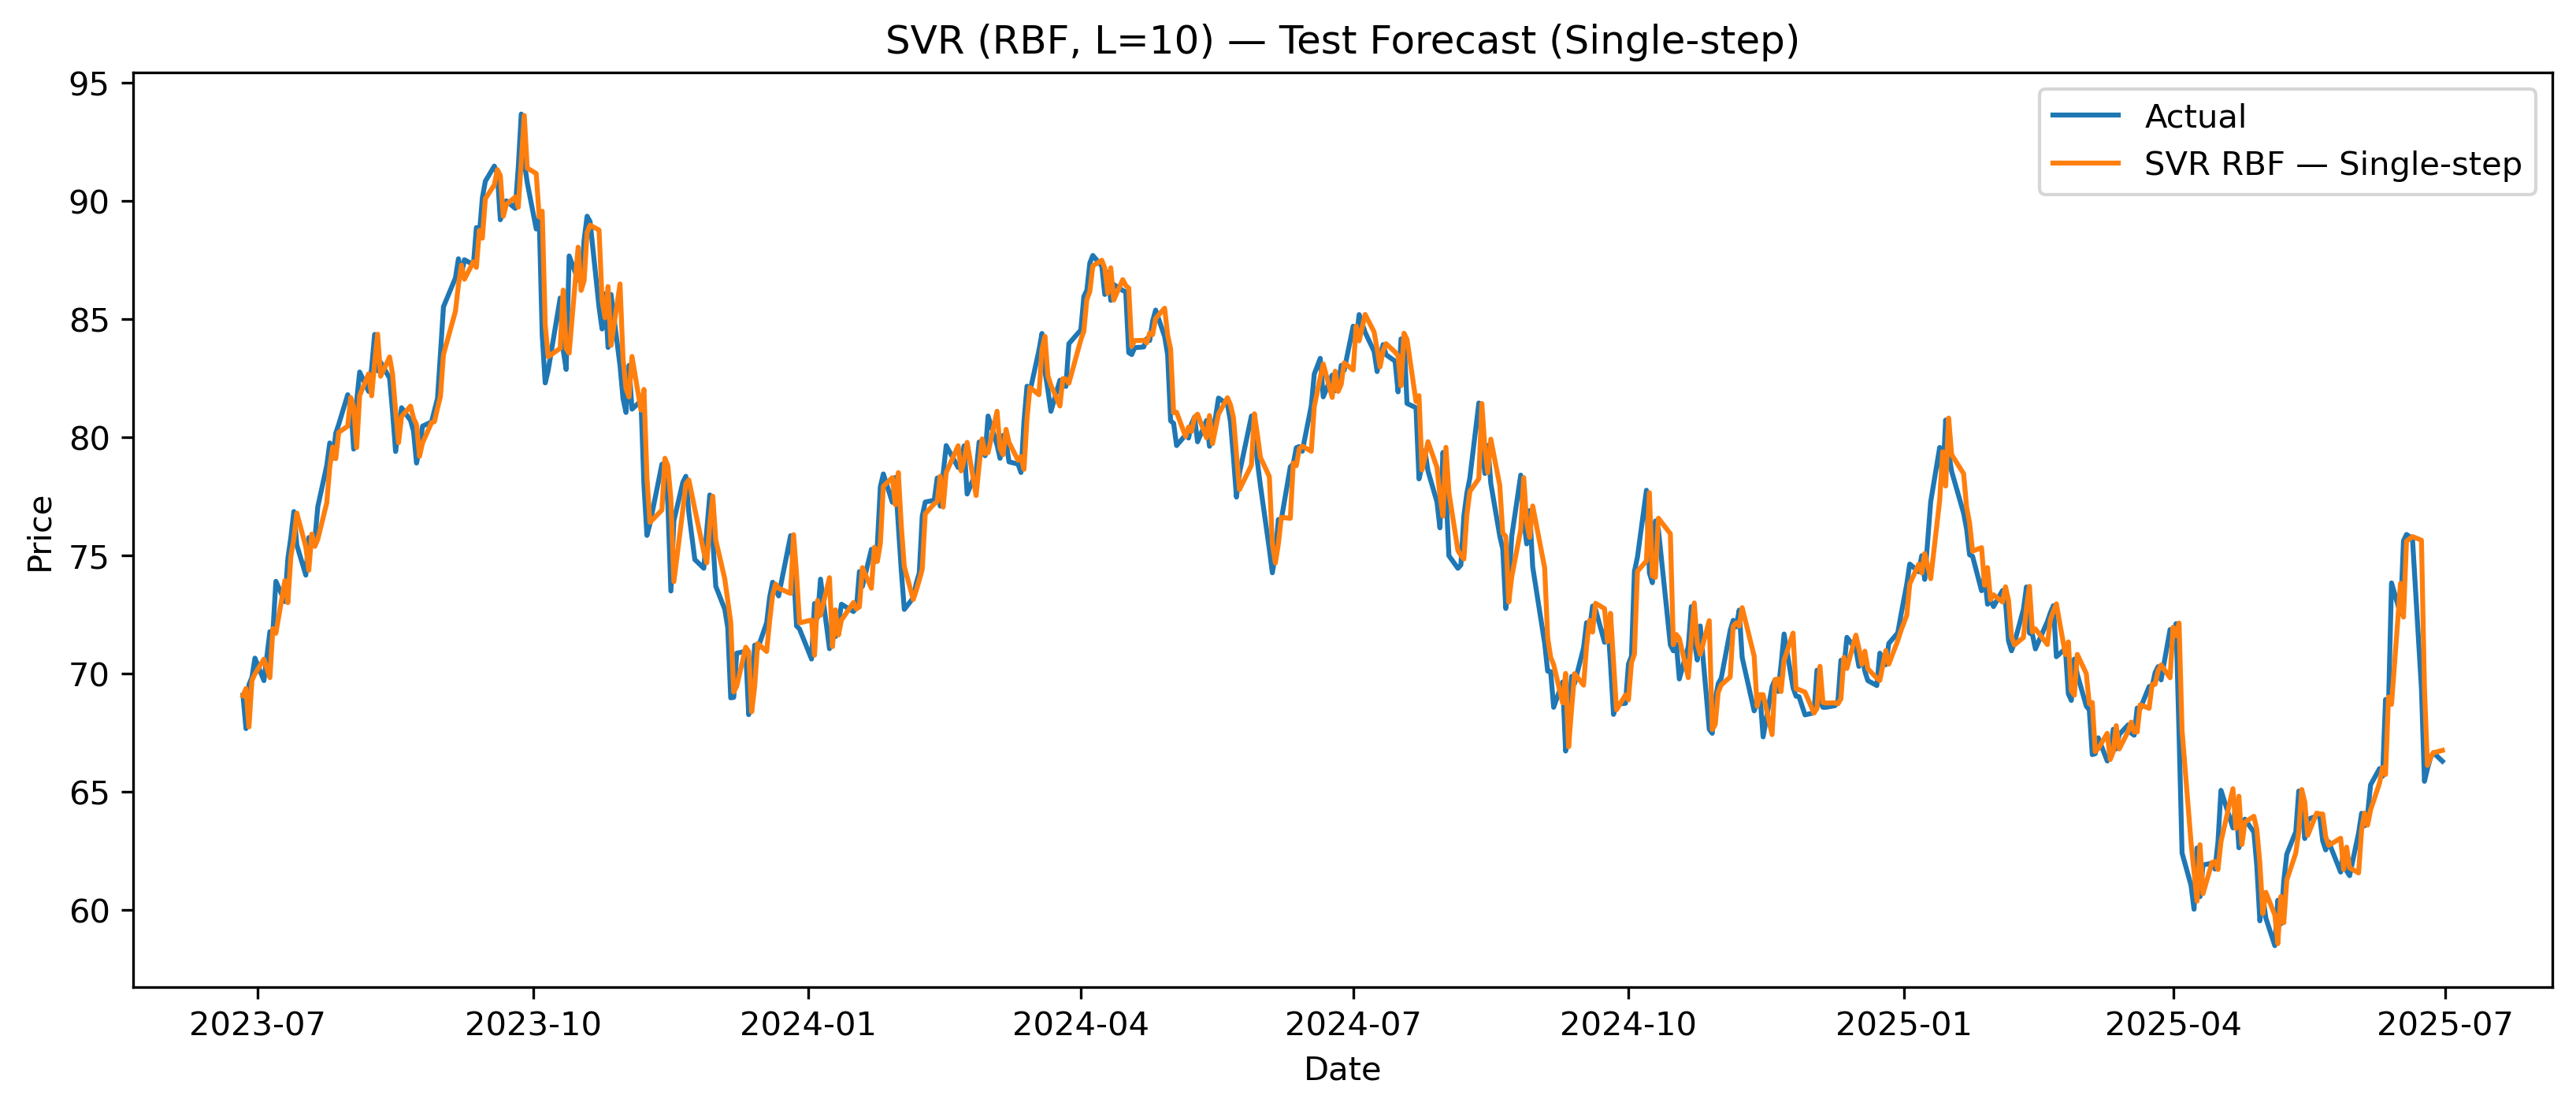

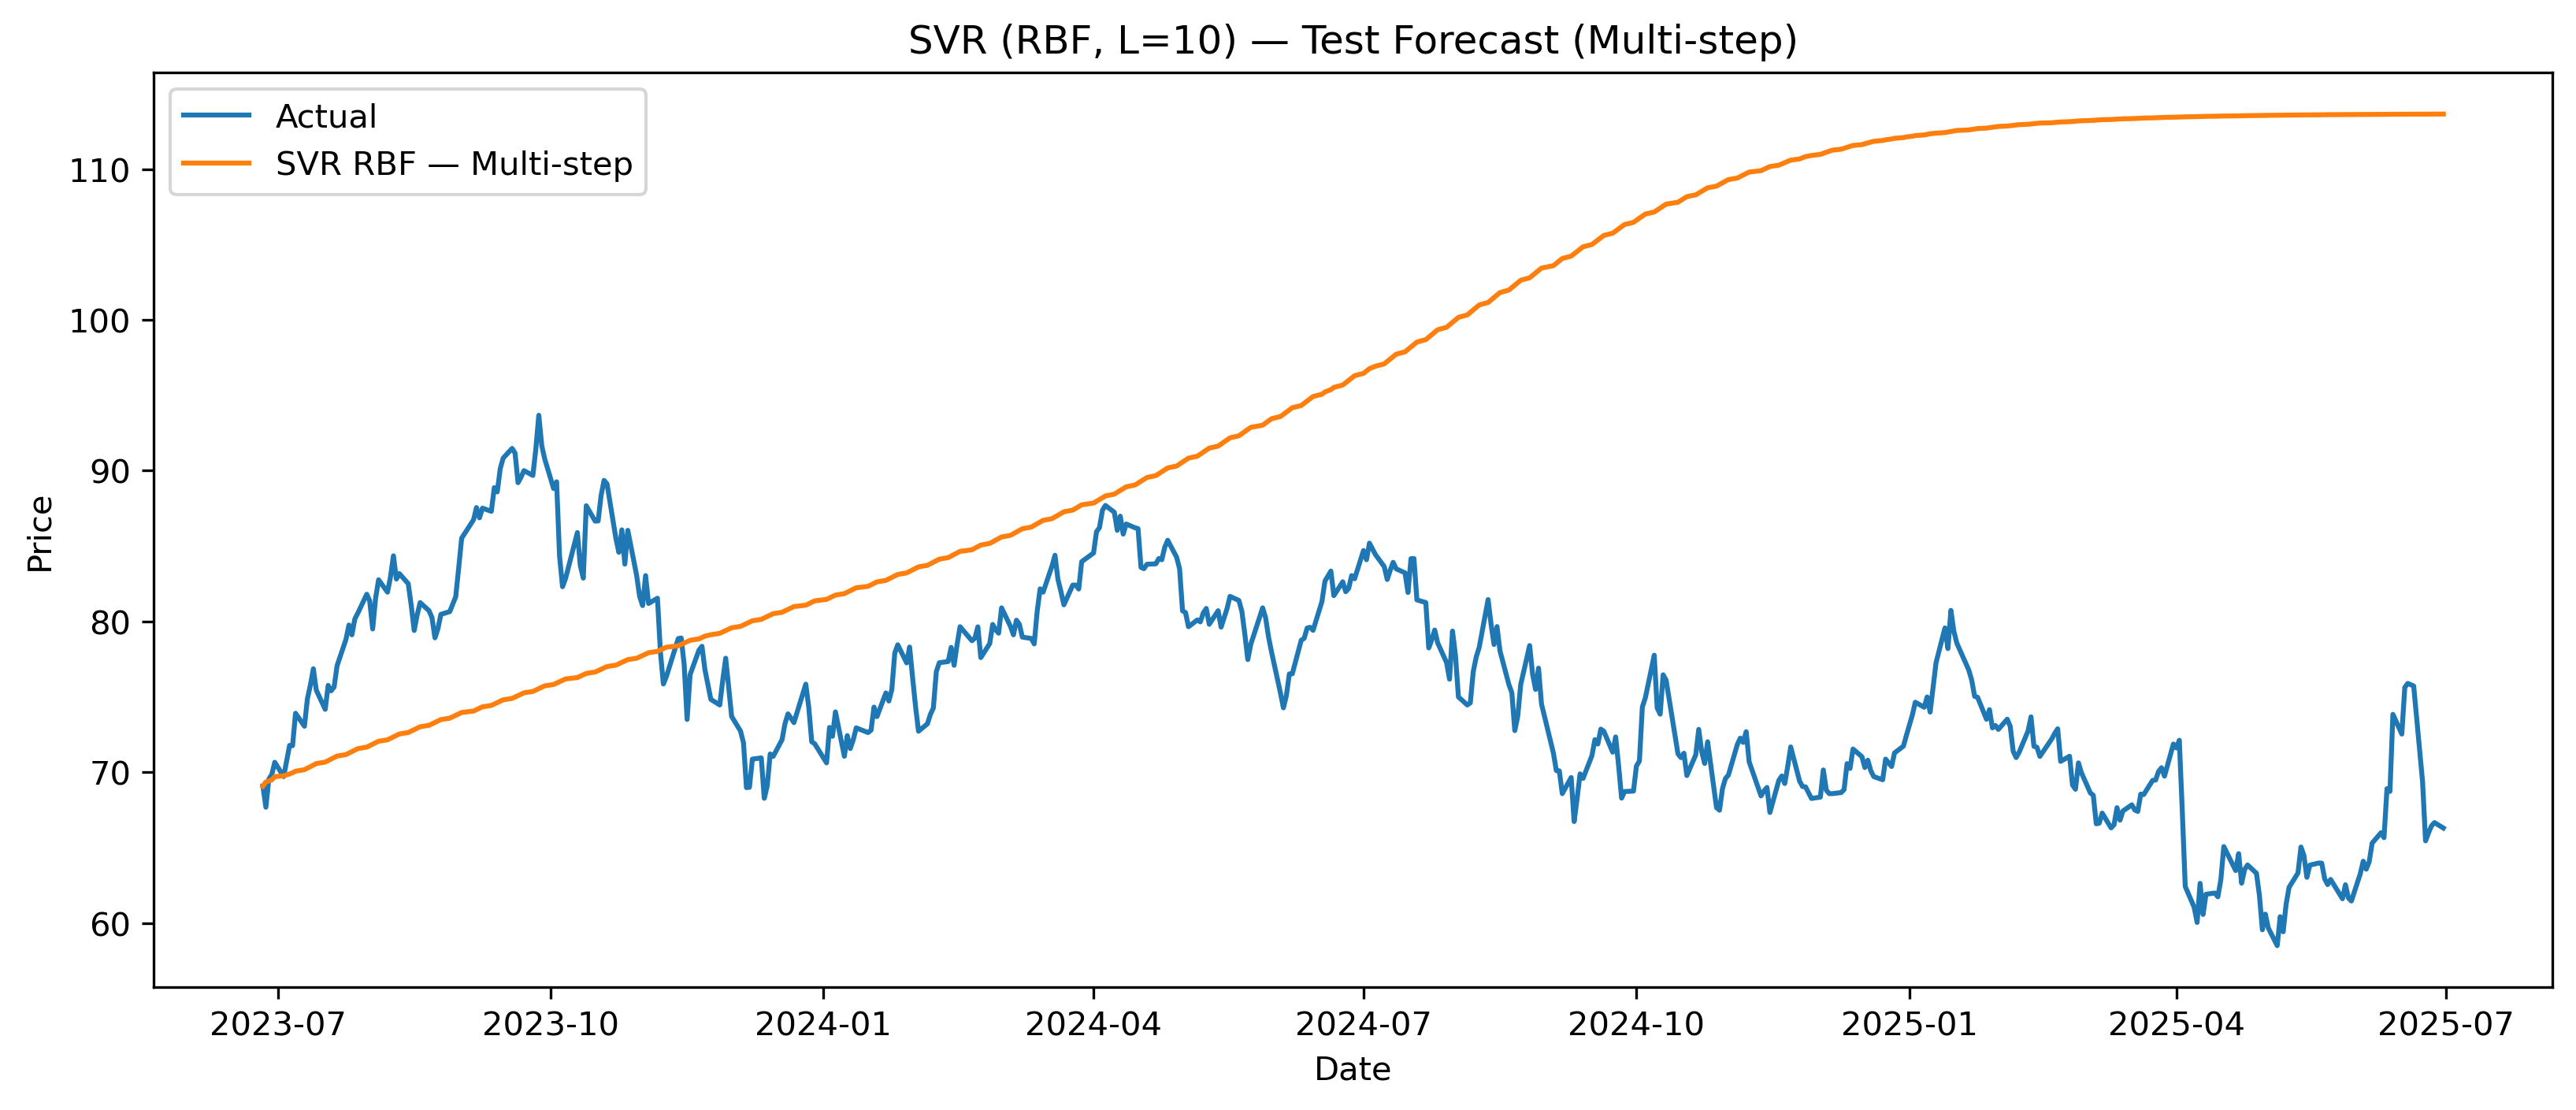

In [17]:
# RBF-SVR @ L=10 — Single-step & Multi-step Prediction (80/20 split)


# Utility Functions 
def make_supervised(series: pd.Series, L: int):
    """Create lagged features [lag_1..lag_L] -> y_t; returns X, y, idx (aligned with y)."""
    df = pd.DataFrame({'y': series})
    for i in range(1, L + 1):
        df[f'lag_{i}'] = series.shift(i)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, L + 1)]].values
    y = df['y'].values
    return X, y, df.index

def make_test_matrix(train_series: pd.Series, test_series: pd.Series, L: int):
    """
    Single-step (truth replace) equivalent "batch construction": use last L items from training + all test 
    to generate true lagged features for each test point.
    """
    s = pd.concat([train_series.iloc[-L:], test_series])
    X_all, y_all, idx_all = make_supervised(s, L)
    assert len(y_all) == len(test_series)
    return X_all, y_all, idx_all

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_safe(y_true, y_pred, eps=1e-6):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    denom = np.clip(np.abs(yt), a_min=eps, a_max=None)
    return np.mean(np.abs(yt - yp) / denom) * 100.0

# Train RBF-SVR (with previously fixed optimal hyperparameters) 
L = 10
X_tr, y_tr, idx_tr = make_supervised(train, L)

rbf_best = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=300, gamma=0.005, epsilon=0.05))
])
rbf_best.fit(X_tr, y_tr)

# Single-step: truth replace (equivalent to batch make_test_matrix) 
X_te_truth, y_te, idx_te = make_test_matrix(train, test, L)
y_pred_single = rbf_best.predict(X_te_truth)

single_metrics = {
    'RMSE': rmse(y_te, y_pred_single),
    'MAE': mean_absolute_error(y_te, y_pred_single),
    'MAPE_%': mape_safe(y_te, y_pred_single)
}

# Multi-step: recursive (rolling with predicted values) 
# Initialize "historical sequence" with the last L true values from training
history = list(train.iloc[-L:].astype(float).values)
y_pred_multi = []

for t in range(len(test)):
    x_t = np.array(history[-L:][::-1])  # Note: in make_supervised, lag_1=previous period ... lag_L=L periods ago
    x_t = x_t.reshape(1, -1)
    yhat = rbf_best.predict(x_t)[0]
    y_pred_multi.append(yhat)

    # Recursive: use "predicted value" as the latest true value in history (different from single-step)
    history.append(yhat)

y_pred_multi = np.array(y_pred_multi)
multi_metrics = {
    'RMSE': rmse(y_te, y_pred_multi),
    'MAE': mean_absolute_error(y_te, y_pred_multi),
    'MAPE_%': mape_safe(y_te, y_pred_multi)
}

#  Print and Export 
print("\n=== RBF-SVR @ L=10: Single-step (truth replace) ===")
print(json.dumps(single_metrics, indent=2))
print("=== RBF-SVR @ L=10: Multi-step (recursive) ===")
print(json.dumps(multi_metrics, indent=2))

os.makedirs('svr_forecast_rbf', exist_ok=True)
pd.DataFrame({
    'Date': idx_te,
    'Actual': y_te,
    'SVR_single': y_pred_single,
    'SVR_multi': y_pred_multi
}).to_csv('svr_forecast_rbf/rbf_L10_single_multi_test.csv', index=False)

# Plot: Actual vs Single-step vs Multi-step 
os.makedirs('svr_forecast_rbf', exist_ok=True)

import matplotlib.pyplot as plt

# Single-step (truth replace)
plt.figure(figsize=(11, 4.8))
plt.plot(idx_te, y_te, label='Actual')
plt.plot(idx_te, y_pred_single, label='SVR RBF — Single-step')
plt.title('SVR (RBF, L=10) — Test Forecast (Single-step)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()   
plt.close()

# Multi-step (recursive)
plt.figure(figsize=(11, 4.8))
plt.plot(idx_te, y_te, label='Actual')
plt.plot(idx_te, y_pred_multi, label='SVR RBF — Multi-step')
plt.title('SVR (RBF, L=10) — Test Forecast (Multi-step)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()   
plt.close()


